In [3]:
import torch
from fuvai import YNet
import os
import cv2
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd



In [6]:
# Model Loading:

input_channels = 1
output_channels = 64
n_class = 1
model = YNet(input_channels=input_channels, output_channels=output_channels, n_class=n_class)

classes=["Fetal brain","Fetal abdomen","Fetal femur","other"]

weight_file_path = "fuvai_weights.pt"  
checkpoint = torch.load(weight_file_path, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [52]:
# Processing Steps: Erosion followed by Dilation

def mask_processing(image):
    # img = cv2.imread("fuvai/segment/Patient01387_Plane5_1_of_1_segment.png")
    img=image

    kernel = np.ones((5, 5), np.uint8)
    kernel_cross=cv2.getStructuringElement(cv2.MORPH_CROSS,(5,5))
    print(kernel_cross)

    opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel_cross,iterations=5)
    eroded_image = cv2.erode(img, kernel, iterations=3)
    dilate_image = cv2.dilate(eroded_image, kernel, iterations=3)


    median_blurred_image = cv2.medianBlur(opening, 13)

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    eroded_image_rgb = cv2.cvtColor(eroded_image, cv2.COLOR_BGR2RGB)
    dilated_image_rgb = cv2.cvtColor(dilate_image, cv2.COLOR_BGR2RGB)
    opening_image_rgb=cv2.cvtColor(opening,cv2.COLOR_BGR2RGB)
    median_blurred_rgb = cv2.cvtColor(opening_image_rgb, cv2.COLOR_BGR2RGB)

    # plt.figure(figsize=(15, 5))


    # plt.subplot(1, 3, 1)
    # plt.imshow(img_rgb)
    # plt.title("Original Image")
    # plt.axis('off')


    # plt.subplot(1, 5, 2)
    # plt.imshow(eroded_image_rgb)
    # plt.title("Eroded Image")
    # plt.axis('off')


    # plt.subplot(1, 5, 3)
    # plt.imshow(dilated_image_rgb)
    # plt.title("Dilated Image")
    # plt.axis('off')



    # plt.subplot(1, 3, 2)
    # plt.imshow(opening_image_rgb)
    # plt.title("Opening Image")
    # plt.axis('off')

    # plt.subplot(1, 3, 3)
    # plt.imshow(median_blurred_rgb)
    # plt.title("Median Blurred Image")
    # plt.axis('off')

    # plt.show()

    return median_blurred_image

    


In [60]:
# Mathematical Formulas for Calculating Circumference:
# Pixel to cm conversion:
#Transformation of Image into required format:
# Overlaying an image over another:

def calculate_ellipse_circumference(a, b):
   
    return np.pi * (3 * (a + b) - np.sqrt((3 * a + b) * (a + 3 * b)))

def pixels_to_cm(pixels, PPI):
    return (pixels / PPI) * 2.54 

transform = transforms.Compose([
        transforms.Resize((224, 224)),  
        transforms.ToTensor(),          
    ])

def overlay(processed_image,image_np):

    alpha = 0.3  
    beta = 0.9 
    gamma = 0    
    print("shape of image",image_np.shape)
    # print("shape of processed image",processed_image.shape)
    if len(image_np.shape) == 2 or image_np.shape[2] == 1:
        image_np = cv2.cvtColor(image_np, cv2.COLOR_GRAY2RGB)
        # print(image_np.shape)
    blended_image = cv2.addWeighted(processed_image,alpha,image_np,beta,gamma)

    return blended_image
    


In [44]:
# Transformation of Image into tensor format:

def img_to_tensor(name,folder,output_folder):
    filename=os.path.join(name+".png")
    image_path=os.path.join(folder,filename)
    image = Image.open(image_path).convert('L')
    image_np=np.array(image)
    print(image_np.shape)
    original_height, original_width = image_np.shape[:2]
    # print(np.array(image))
    output_path=os.path.join(output_folder,filename)
    image.save(output_path)


    tensor=transform(image)
    print(tensor.shape)

    image_tensor = tensor.unsqueeze(0)
    
    return image_tensor,original_height,original_width,image_np

In [97]:
def contour_detect(img,predicted_class,blended_image):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret, thresh = cv2.threshold(gray, 75, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    contour_img = img.copy()

    for cnt in contours:
        epsilon = 0.005 * cv2.arcLength(cnt, True)  
        approx = cv2.approxPolyDP(cnt, epsilon, True)
        cv2.drawContours(contour_img, [approx], -1, (255, 0, 0), 2)
        classes_cnt=["Fetal brain","Fetal abdomen"]
        if predicted_class in classes_cnt:
            if len(approx) >= 5:
                ellipse = cv2.fitEllipse(approx)
                (x, y), (minor_axis, major_axis), angle = ellipse
                if major_axis>250:
                
                    cv2.ellipse(blended_image, ellipse, (0, 255, 255), 2)

                    
                    a = major_axis / 2
                    b = minor_axis / 2
                    print("B",b)
                    print(x)
                    print(y)

                    angle_rad = np.deg2rad(angle)
                    x_center, y_center = int(x), int(y)

            
                    x_offset = int(b * np.sin(angle_rad + np.pi / 2))
                    y_offset = int(b * np.cos(angle_rad + np.pi / 2))   

                    pt1 = (x_center , y_center - y_offset)  # One end of the minor axis
                    pt2 = (x_center , y_center + y_offset) 
                    print(pt1)
                    print(pt2)

                    # pt1=(0,int(-b))
                    # pt2=(0,int(b))
                
                    cv2.line(blended_image, pt1, pt2, (0, 255, 255), 2)
                
                    circumference = calculate_ellipse_circumference(a, b)
                    circumference_in_cm=pixels_to_cm(circumference,224)


                    bpd=pixels_to_cm(minor_axis,224)
                    bpd_text=f"BPD (Short Axis): {bpd:.2f}cm"

                    print(f"Ellipse fitted: Major Axis = {major_axis}, Minor Axis = {minor_axis}")
                    print(f"Circumference: {circumference_in_cm:.2f}")
                    circum=f"Circumference: {circumference_in_cm:.2f}cm"
                    print(f"BPD: {minor_axis:.2f}")
                    cv2.putText(blended_image,circum,(0,50),cv2.FONT_HERSHEY_COMPLEX,0.8,(255,0,0),2,cv2.LINE_AA)
                    cv2.putText(blended_image,bpd_text,(0,100),cv2.FONT_HERSHEY_COMPLEX,0.8,(255,0,0),2,cv2.LINE_AA)
        else:
            # x, y, w, h = cv2.boundingRect(cnt)
            # if w>200:
            #     cv2.rectangle(blended_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
                    
            #     length_in_cm=pixels_to_cm(w,224)
            #     Length=f"Length of the Bone is: {length_in_cm:.2f}cm"

            #     cv2.putText(blended_image,Length,(x,y-20),cv2.FONT_HERSHEY_COMPLEX,1,(255,0,0),4,cv2.LINE_AA)
            rect = cv2.minAreaRect(cnt)
            box = cv2.boxPoints(rect)  
            box = np.int32(box) 
            width = int(rect[1][0])  # width of the rectangle
            height = int(rect[1][1])
            # if width>200:
            cv2.drawContours(blended_image, [box], 0, (0, 255, 0), 2)
            length_in_cm = pixels_to_cm(max(width, height), 224)
            Length = f"Length of the Bone is: {length_in_cm:.2f}cm"
            cv2.putText(blended_image, Length, (int(box[0][0]), int(box[0][1]) - 20), 
            cv2.FONT_HERSHEY_COMPLEX, 1, (255, 0, 0), 4, cv2.LINE_AA)

    contour_img_rgb = cv2.cvtColor(contour_img, cv2.COLOR_BGR2RGB)
    return blended_image
    # plt.figure(figsize=(10, 10))
    # plt.imshow(contour_img_rgb)
    # plt.title("Result")
    # plt.axis('off')
    # plt.show()



In [ ]:
#Generation of mask:

def mask_generation(segmentation_output,original_width,original_height):

    out = segmentation_output.squeeze().cpu().detach().numpy()
        # print(out)
        # print(out.shape)
    binary_mask = (out > 0.5).astype(np.uint8)
    print(binary_mask)

    red_mask = np.zeros((binary_mask.shape[0], binary_mask.shape[1], 3), dtype=np.uint8)
    red_mask[binary_mask == 1] = [0, 0, 255] 
    resized_red_mask = cv2.resize(red_mask, (original_width, original_height), interpolation=cv2.INTER_LINEAR)
    print("SHAPE",resized_red_mask.shape)
    return resized_red_mask

In [ ]:
#Making modifications in Csv File:

import pandas as pd


# df = pd.read_csv("FETAL_PLANES_DB_data.csv", sep=";")
# print(df.head())
# keep_values = ["Fetal abdomen", "Fetal brain", "Fetal femur"]

# # df['Plane'] = df['Plane'].apply(lambda x: x if x in keep_values else 'Other')
# # print(df)
# # df.to_excel('updated.xlsx', index=False)


# df=pd.read_excel("updated.xlsx")
# print(df.head())

# import pandas as pd

# categories = ['Fetal abdomen', 'Fetal femur', 'Fetal brain', 'Other']

# sampled_df = pd.concat([df[df['Plane'] == category].sample(20, random_state=42) for category in categories])


# sampled_df = sampled_df.reset_index(drop=True)

# sampled_df.to_excel('sampled_files_with_columns.xlsx', index=False)

# print("Sampled data with all columns saved to Excel file successfully!")


In [ ]:
#Bitwise Approach

def bit_wise(image1,image2):
    # img1=cv2.imread("segment.png")
    img1=image1
    print(img1.shape)

    # img2=cv2.imread("Patient01432_Plane5_2_of_2.png")
    img2=image2
    img2=cv2.resize(img2,(224,224))
    print(img2.shape)
    final_image=cv2.bitwise_and(img2,img1)

    plt.imshow(final_image)
    plt.show()

    cv2.imwrite("segemented_part.png",final_image)

(392, 640)
torch.Size([1, 224, 224])
392 640
(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.1490, 0.2039, 0.1843,  ..., 0.1922, 0.1882, 0.1922],
         [0.1294, 0.2000, 0.2000,  ..., 0.1922, 0.1922, 0.1922],
         [0.1176, 0.1725, 0.1922,  ..., 0.1843, 0.1765, 0.1725]]]),)


/Users/vinu/miniconda3/envs/dicom/lib/python3.9/site-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Fully connected output: torch.Size([1, 4])
Segmentation output: torch.Size([1, 1, 224, 224])
Class probabilities: tensor([[8.1229e-06, 9.9996e-01, 9.3882e-08, 3.4583e-05]])
Predicted class: Fetal abdomen

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
SHAPE (392, 640, 3)
<class 'numpy.ndarray'>
[[0 0 1 0 0]
 [0 0 1 0 0]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 1 0 0]]
shape of image (392, 640)
B 149.7425537109375
358.3168029785156
180.6526336669922
(358, 323)
(358, 37)
Ellipse fitted: Major Axis = 339.9280700683594, Minor Axis = 299.485107421875
Circumference: 11.40
BPD: 299.49


/Users/vinu/Documents/humonics/fuvai/fuvai.py:221: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src, size=tar.shape[2:], mode='bilinear')


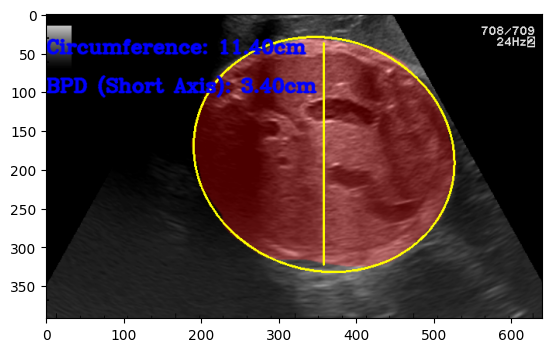

(392, 640)
torch.Size([1, 224, 224])
392 640
(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.1922, 0.2588, 0.2549,  ..., 0.2824, 0.2902, 0.2863],
         [0.1765, 0.2431, 0.2471,  ..., 0.2745, 0.2706, 0.2588],
         [0.1725, 0.2353, 0.2392,  ..., 0.2667, 0.2588, 0.2510]]]),)
Fully connected output: torch.Size([1, 4])
Segmentation output: torch.Size([1, 1, 224, 224])
Class probabilities: tensor([[1.0539e-06, 9.9993e-01, 7.5402e-10, 6.5456e-05]])
Predicted class: Fetal abdomen

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
SHAPE (392, 640, 3)
<class 'numpy.ndarray'>
[[0 0 1 0 0]
 [0 0 1 0 0]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 1 0 0]]
shape of image (392, 640)
B 155.992919921875
341.1007080078125
196.4144744873047
(341, 322)
(341, 70)
Ellipse f

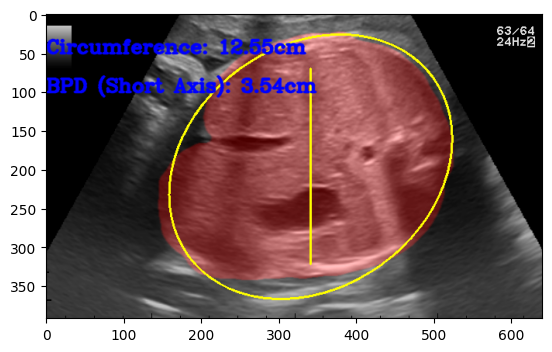

(663, 961)
torch.Size([1, 224, 224])
663 961
(tensor([[[0.0275, 0.0275, 0.0275,  ..., 0.0275, 0.0275, 0.0275],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.3333, 0.2275, 0.0039],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]]),)
Fully connected output: torch.Size([1, 4])
Segmentation output: torch.Size([1, 1, 224, 224])
Class probabilities: tensor([[1.0276e-04, 9.9990e-01, 5.4812e-09, 1.9146e-06]])
Predicted class: Fetal abdomen

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
SHAPE (663, 961, 3)
<class 'numpy.ndarray'>
[[0 0 1 0 0]
 [0 0 1 0 0]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 1 0 0]]
shape of image (663, 961)
B 225.2161865234375
457.2631530761719
321.60491943359375
(457, 520)
(457, 122)
Ellips

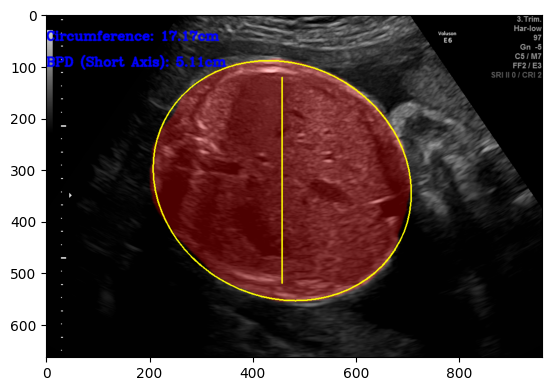

(392, 640)
torch.Size([1, 224, 224])
392 640
(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]),)
Fully connected output: torch.Size([1, 4])
Segmentation output: torch.Size([1, 1, 224, 224])
Class probabilities: tensor([[7.2263e-05, 9.9946e-01, 8.4465e-08, 4.6406e-04]])
Predicted class: Fetal abdomen

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
SHAPE (392, 640, 3)
<class 'numpy.ndarray'>
[[0 0 1 0 0]
 [0 0 1 0 0]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 1 0 0]]
shape of image (392, 640)
B 132.3697052001953
374.05340576171875
189.60394287109375
(374, 320)
(374, 58)
Ellipse fitted: Major Axis = 325.6530456542969, Minor Axis = 264.7394104003906
Circumference: 10.54
BPD: 264.74


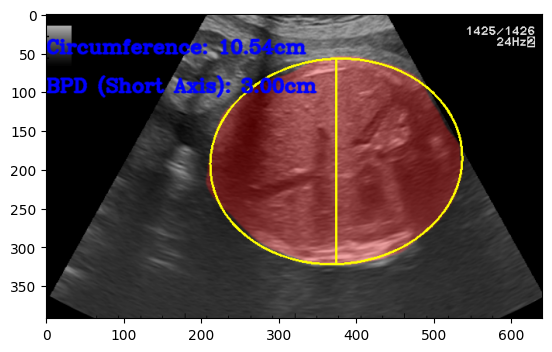

(787, 1137)
torch.Size([1, 224, 224])
787 1137
(tensor([[[0.0157, 0.0157, 0.0157,  ..., 0.0157, 0.0157, 0.0157],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.1255, 0.1098, 0.0039],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]]),)
Fully connected output: torch.Size([1, 4])
Segmentation output: torch.Size([1, 1, 224, 224])
Class probabilities: tensor([[7.0847e-06, 9.9999e-01, 1.0304e-10, 1.2856e-07]])
Predicted class: Fetal abdomen

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
SHAPE (787, 1137, 3)
<class 'numpy.ndarray'>
[[0 0 1 0 0]
 [0 0 1 0 0]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 1 0 0]]
shape of image (787, 1137)
B 287.86700439453125
544.925048828125
424.2313232421875
(544, 702)
(544, 146)
Ell

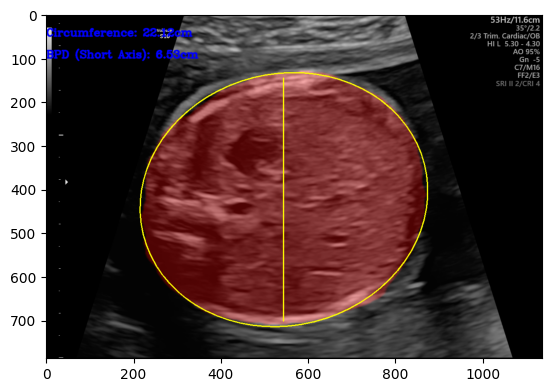

(787, 1137)
torch.Size([1, 224, 224])
787 1137
(tensor([[[0.0157, 0.0157, 0.0157,  ..., 0.0157, 0.0157, 0.0157],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.1255, 0.1098, 0.0039],
         ...,
         [0.0510, 0.0549, 0.0549,  ..., 0.2235, 0.2353, 0.1922],
         [0.0627, 0.0627, 0.0627,  ..., 0.2353, 0.2235, 0.1569],
         [0.0549, 0.0627, 0.0549,  ..., 0.1961, 0.1608, 0.1098]]]),)
Fully connected output: torch.Size([1, 4])
Segmentation output: torch.Size([1, 1, 224, 224])
Class probabilities: tensor([[5.8887e-06, 9.9999e-01, 7.5619e-10, 4.0709e-06]])
Predicted class: Fetal abdomen

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
SHAPE (787, 1137, 3)
<class 'numpy.ndarray'>
[[0 0 1 0 0]
 [0 0 1 0 0]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 1 0 0]]
shape of image (787, 1137)
B 222.94454956054688
561.4068603515625
388.6611633300781
(561, 608)
(561, 168)
El

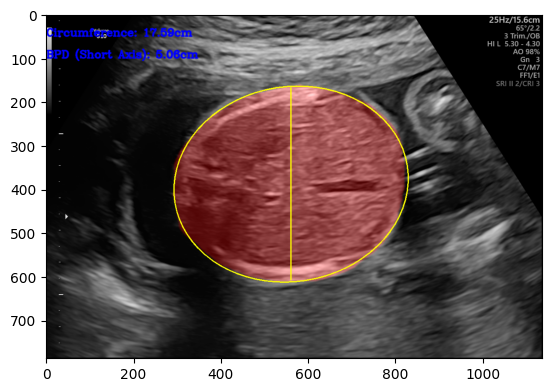

(661, 959)
torch.Size([1, 224, 224])
661 959
(tensor([[[0.0863, 0.0549, 0.0353,  ..., 0.0510, 0.0431, 0.0392],
         [0.0824, 0.0706, 0.0588,  ..., 0.3843, 0.3412, 0.2745],
         [0.0431, 0.0549, 0.0510,  ..., 0.4706, 0.4549, 0.2941],
         ...,
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0118, 0.0157, 0.0078,  ..., 0.0039, 0.0039, 0.0039]]]),)
Fully connected output: torch.Size([1, 4])
Segmentation output: torch.Size([1, 1, 224, 224])
Class probabilities: tensor([[9.2981e-08, 1.0000e+00, 1.8972e-09, 2.8623e-06]])
Predicted class: Fetal abdomen

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
SHAPE (661, 959, 3)
<class 'numpy.ndarray'>
[[0 0 1 0 0]
 [0 0 1 0 0]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 1 0 0]]
shape of image (661, 959)
B 251.668212890625
538.1819458007812
282.37005615234375
(538, 533)
(538, 31)
Ellipse 

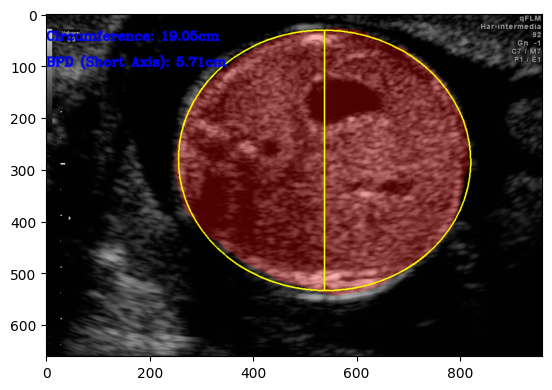

(661, 959)
torch.Size([1, 224, 224])
661 959
(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0588, 0.1569, 0.0745],
         [0.0000, 0.0000, 0.0000,  ..., 0.2784, 0.4039, 0.2039],
         ...,
         [0.1020, 0.1412, 0.1490,  ..., 0.0000, 0.0000, 0.0000],
         [0.0549, 0.1059, 0.1490,  ..., 0.0000, 0.0000, 0.0000],
         [0.0235, 0.0706, 0.1451,  ..., 0.0000, 0.0000, 0.0000]]]),)
Fully connected output: torch.Size([1, 4])
Segmentation output: torch.Size([1, 1, 224, 224])
Class probabilities: tensor([[0.0011, 0.9797, 0.0011, 0.0181]])
Predicted class: Fetal abdomen

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
SHAPE (661, 959, 3)
<class 'numpy.ndarray'>
[[0 0 1 0 0]
 [0 0 1 0 0]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 1 0 0]]
shape of image (661, 959)
B 262.34619140625
445.6011962890625
401.1227722167969
(445, 662)
(445, 140)
Ellipse fitted: Major Axi

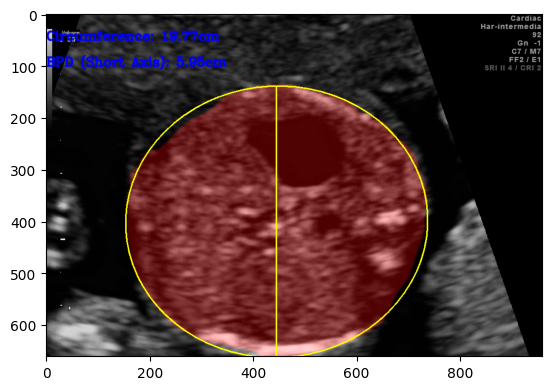

(392, 640)
torch.Size([1, 224, 224])
392 640
(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.1176, 0.1569, 0.1451,  ..., 0.7255, 0.7176, 0.6980],
         [0.1176, 0.1608, 0.1686,  ..., 0.7059, 0.7059, 0.7020],
         [0.0588, 0.1255, 0.1647,  ..., 0.7137, 0.7216, 0.7137]]]),)
Fully connected output: torch.Size([1, 4])
Segmentation output: torch.Size([1, 1, 224, 224])
Class probabilities: tensor([[1.6052e-04, 9.9448e-01, 5.8251e-09, 5.3574e-03]])
Predicted class: Fetal abdomen

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
SHAPE (392, 640, 3)
<class 'numpy.ndarray'>
[[0 0 1 0 0]
 [0 0 1 0 0]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 1 0 0]]
shape of image (392, 640)
B 141.76239013671875
349.8703308105469
182.8745880126953
(349, 322)
(349, 42)
Ellipse

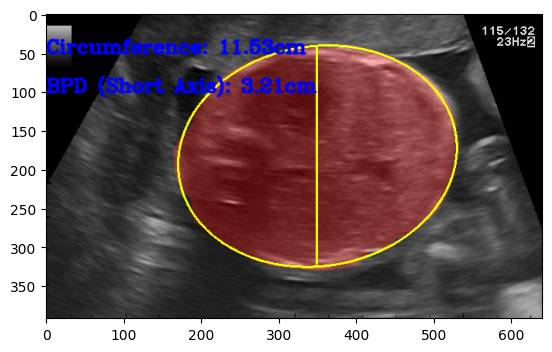

(787, 1137)
torch.Size([1, 224, 224])
787 1137
(tensor([[[0.0157, 0.0157, 0.0157,  ..., 0.0157, 0.0157, 0.0157],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.1255, 0.1098, 0.0039],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]]),)
Fully connected output: torch.Size([1, 4])
Segmentation output: torch.Size([1, 1, 224, 224])
Class probabilities: tensor([[3.3546e-05, 9.9997e-01, 1.8747e-07, 8.4745e-07]])
Predicted class: Fetal abdomen

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
SHAPE (787, 1137, 3)
<class 'numpy.ndarray'>
[[0 0 1 0 0]
 [0 0 1 0 0]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 1 0 0]]
shape of image (787, 1137)
B 188.92855834960938
559.2525024414062
280.8319091796875
(559, 467)
(559, 93)
Ell

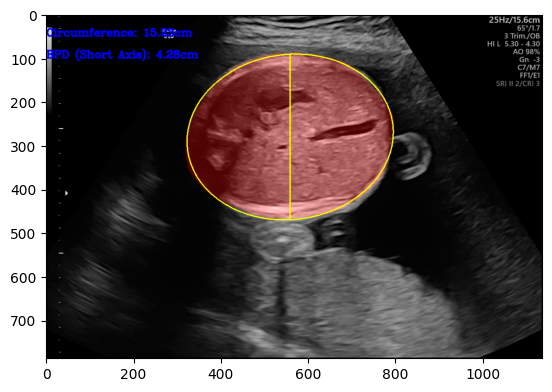

(661, 959)
torch.Size([1, 224, 224])
661 959
(tensor([[[0.0941, 0.1294, 0.1490,  ..., 0.3176, 0.3529, 0.3176],
         [0.1333, 0.1686, 0.1882,  ..., 0.5020, 0.4745, 0.3765],
         [0.1373, 0.1647, 0.1843,  ..., 0.4902, 0.3922, 0.3569],
         ...,
         [0.1333, 0.1647, 0.1647,  ..., 0.2314, 0.1961, 0.1686],
         [0.1529, 0.1686, 0.1725,  ..., 0.2039, 0.1686, 0.1490],
         [0.1961, 0.1961, 0.1765,  ..., 0.1725, 0.1412, 0.1255]]]),)
Fully connected output: torch.Size([1, 4])
Segmentation output: torch.Size([1, 1, 224, 224])
Class probabilities: tensor([[6.7902e-03, 9.8884e-01, 5.3689e-05, 4.3186e-03]])
Predicted class: Fetal abdomen

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
SHAPE (661, 959, 3)
<class 'numpy.ndarray'>
[[0 0 1 0 0]
 [0 0 1 0 0]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 1 0 0]]
shape of image (661, 959)
B 226.63465881347656
583.203857421875
352.4610900878906
(583, 578)
(583, 126)
Ellipse

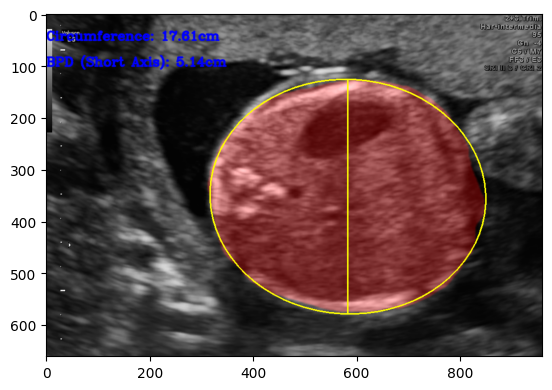

(392, 640)
torch.Size([1, 224, 224])
392 640
(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.2784, 0.1804, 0.0431],
         [0.0000, 0.0000, 0.0000,  ..., 0.0863, 0.0118, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000]]]),)
Fully connected output: torch.Size([1, 4])
Segmentation output: torch.Size([1, 1, 224, 224])
Class probabilities: tensor([[3.3831e-06, 9.9990e-01, 1.4114e-07, 9.9442e-05]])
Predicted class: Fetal abdomen

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
SHAPE (392, 640, 3)
<class 'numpy.ndarray'>
[[0 0 1 0 0]
 [0 0 1 0 0]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 1 0 0]]
shape of image (392, 640)
B 138.30812072753906
333.07525634765625
184.00738525390625
(333, 315)
(333, 53)
Ellip

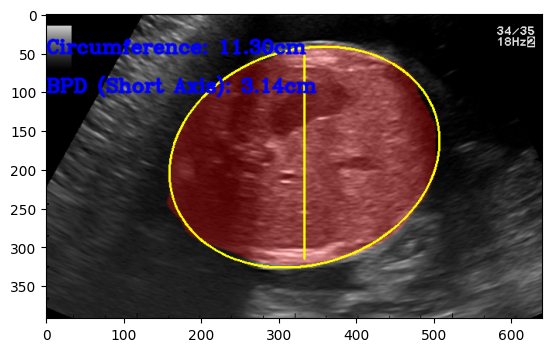

(392, 640)
torch.Size([1, 224, 224])
392 640
(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.1059, 0.1373, 0.1333,  ..., 0.1882, 0.1961, 0.2000],
         [0.1176, 0.1529, 0.1412,  ..., 0.1882, 0.1922, 0.1804],
         [0.1176, 0.1647, 0.1529,  ..., 0.1843, 0.1804, 0.1725]]]),)
Fully connected output: torch.Size([1, 4])
Segmentation output: torch.Size([1, 1, 224, 224])
Class probabilities: tensor([[6.6516e-06, 9.9999e-01, 4.9564e-09, 4.9936e-06]])
Predicted class: Fetal abdomen

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
SHAPE (392, 640, 3)
<class 'numpy.ndarray'>
[[0 0 1 0 0]
 [0 0 1 0 0]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 1 0 0]]
shape of image (392, 640)
B 137.60888671875
351.1679992675781
196.66470336914062
(351, 328)
(351, 64)
Ellipse f

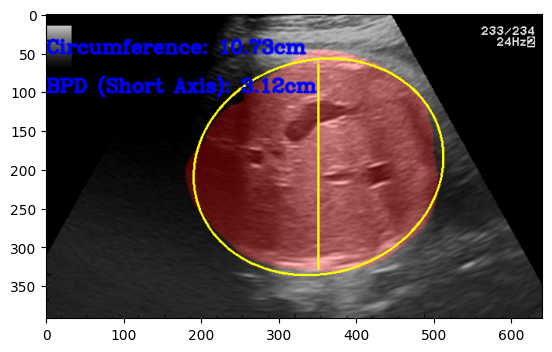

(661, 959)
torch.Size([1, 224, 224])
661 959
(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.1647, 0.0431, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.4510, 0.1725, 0.0000],
         ...,
         [0.1098, 0.1529, 0.1490,  ..., 0.0000, 0.0000, 0.0000],
         [0.0745, 0.1137, 0.1373,  ..., 0.0000, 0.0000, 0.0000],
         [0.0510, 0.0667, 0.0706,  ..., 0.0000, 0.0000, 0.0000]]]),)
Fully connected output: torch.Size([1, 4])
Segmentation output: torch.Size([1, 1, 224, 224])
Class probabilities: tensor([[1.0668e-03, 9.8697e-01, 9.7666e-05, 1.1866e-02]])
Predicted class: Fetal abdomen

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
SHAPE (661, 959, 3)
<class 'numpy.ndarray'>
[[0 0 1 0 0]
 [0 0 1 0 0]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 1 0 0]]
shape of image (661, 959)
B 209.03314208984375
513.9779052734375
250.1099395751953
(513, 458)
(513, 42)
Ellipse

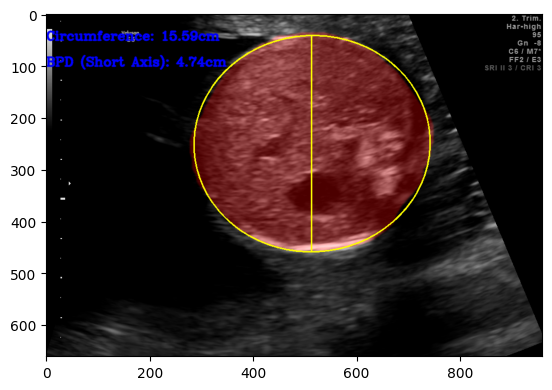

(661, 959)
torch.Size([1, 224, 224])
661 959
(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.1647, 0.0431, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.4510, 0.1725, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.2745, 0.2863, 0.2863],
         [0.0000, 0.0000, 0.0000,  ..., 0.2275, 0.2235, 0.2000],
         [0.0000, 0.0000, 0.0000,  ..., 0.2039, 0.1804, 0.1451]]]),)
Fully connected output: torch.Size([1, 4])
Segmentation output: torch.Size([1, 1, 224, 224])
Class probabilities: tensor([[6.3193e-05, 9.9992e-01, 9.1986e-08, 1.4516e-05]])
Predicted class: Fetal abdomen

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
SHAPE (661, 959, 3)
<class 'numpy.ndarray'>
[[0 0 1 0 0]
 [0 0 1 0 0]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 1 0 0]]
shape of image (661, 959)
B 229.49847412109375
479.77081298828125
260.366455078125
(479, 489)
(479, 31)
Ellipse

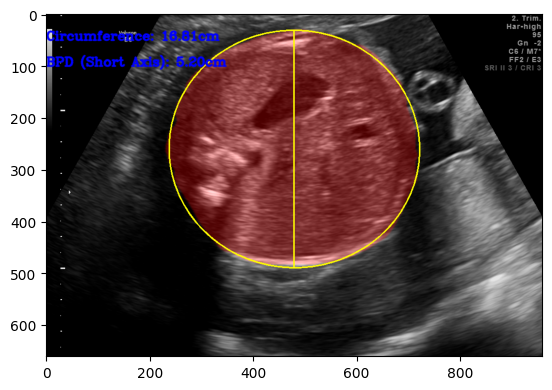

(392, 640)
torch.Size([1, 224, 224])
392 640
(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.1412, 0.2039, 0.2275,  ..., 0.2392, 0.2471, 0.2392],
         [0.1490, 0.1961, 0.2118,  ..., 0.2431, 0.2392, 0.2392],
         [0.1725, 0.2275, 0.2157,  ..., 0.2353, 0.2431, 0.2431]]]),)
Fully connected output: torch.Size([1, 4])
Segmentation output: torch.Size([1, 1, 224, 224])
Class probabilities: tensor([[2.6391e-04, 9.5378e-01, 2.5543e-06, 4.5957e-02]])
Predicted class: Fetal abdomen

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
SHAPE (392, 640, 3)
<class 'numpy.ndarray'>
[[0 0 1 0 0]
 [0 0 1 0 0]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 1 0 0]]
shape of image (392, 640)
B 158.99436950683594
364.29559326171875
191.3586883544922
(364, 324)
(364, 58)
Ellips

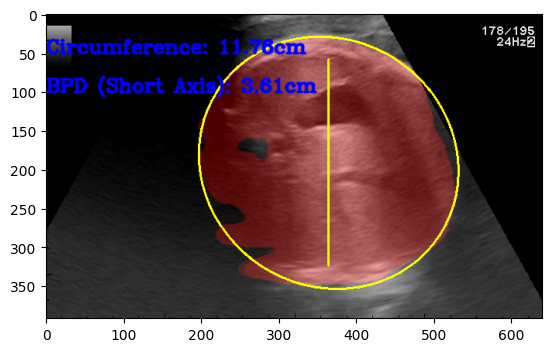

(392, 640)
torch.Size([1, 224, 224])
392 640
(tensor([[[0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
         [0.0196, 0.0196, 0.0118,  ..., 0.0000, 0.0000, 0.0000],
         [0.0196, 0.0196, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0471, 0.0627, 0.0588,  ..., 0.4314, 0.3882, 0.3647],
         [0.0510, 0.0784, 0.0627,  ..., 0.3686, 0.3255, 0.3765],
         [0.0431, 0.0667, 0.0510,  ..., 0.3373, 0.3255, 0.4157]]]),)
Fully connected output: torch.Size([1, 4])
Segmentation output: torch.Size([1, 1, 224, 224])
Class probabilities: tensor([[5.6263e-07, 9.9994e-01, 2.8766e-08, 5.7796e-05]])
Predicted class: Fetal abdomen

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
SHAPE (392, 640, 3)
<class 'numpy.ndarray'>
[[0 0 1 0 0]
 [0 0 1 0 0]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 1 0 0]]
shape of image (392, 640)
B 146.19528198242188
325.9677734375
201.70217895507812
(325, 345)
(325, 57)
Ellipse f

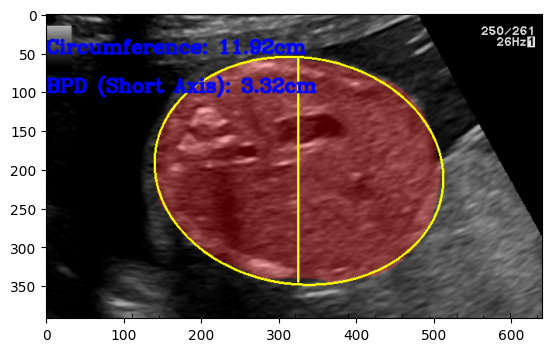

(661, 959)
torch.Size([1, 224, 224])
661 959
(tensor([[[0.1608, 0.1961, 0.1098,  ..., 0.0784, 0.0510, 0.0510],
         [0.1922, 0.2627, 0.1882,  ..., 0.3922, 0.3451, 0.2824],
         [0.1529, 0.2118, 0.2314,  ..., 0.4706, 0.4549, 0.3059],
         ...,
         [0.3216, 0.3922, 0.3843,  ..., 0.0157, 0.0235, 0.0235],
         [0.2941, 0.3373, 0.3294,  ..., 0.0118, 0.0157, 0.0118],
         [0.3529, 0.4000, 0.3922,  ..., 0.0039, 0.0039, 0.0039]]]),)
Fully connected output: torch.Size([1, 4])
Segmentation output: torch.Size([1, 1, 224, 224])
Class probabilities: tensor([[4.5782e-07, 9.9992e-01, 1.1982e-05, 6.6296e-05]])
Predicted class: Fetal abdomen

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
SHAPE (661, 959, 3)
<class 'numpy.ndarray'>
[[0 0 1 0 0]
 [0 0 1 0 0]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 1 0 0]]
shape of image (661, 959)
B 228.55191040039062
511.70269775390625
281.0220642089844
(511, 492)
(511, 70)
Ellips

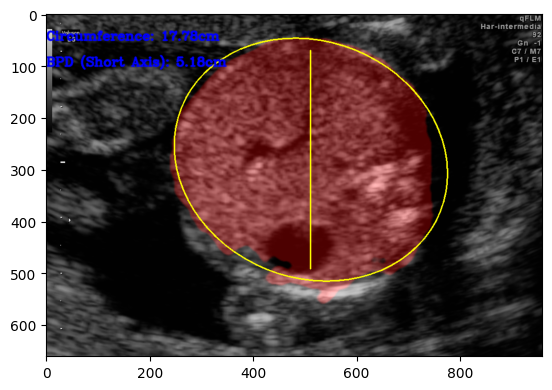

(392, 640)
torch.Size([1, 224, 224])
392 640
(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0353, 0.0431, 0.0275,  ..., 0.0000, 0.0000, 0.0000],
         [0.0196, 0.0392, 0.0471,  ..., 0.0000, 0.0000, 0.0000],
         [0.0118, 0.0157, 0.0196,  ..., 0.0000, 0.0000, 0.0000]]]),)
Fully connected output: torch.Size([1, 4])
Segmentation output: torch.Size([1, 1, 224, 224])
Class probabilities: tensor([[1.5855e-07, 9.9999e-01, 8.6731e-09, 7.1599e-06]])
Predicted class: Fetal abdomen

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
SHAPE (392, 640, 3)
<class 'numpy.ndarray'>
[[0 0 1 0 0]
 [0 0 1 0 0]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 1 0 0]]
shape of image (392, 640)
B 167.85337829589844
415.8503723144531
187.9243927001953
(415, 354)
(415, 20)
Ellipse

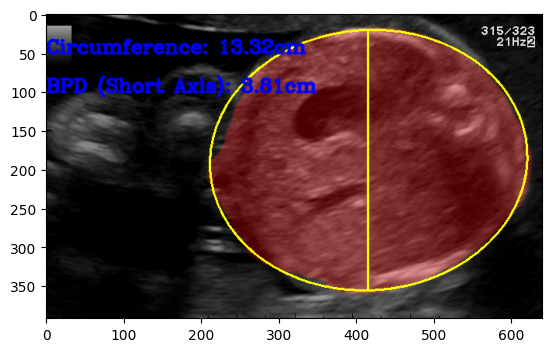

(661, 959)
torch.Size([1, 224, 224])
661 959
(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.1647, 0.0431, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.4510, 0.1725, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]]),)
Fully connected output: torch.Size([1, 4])
Segmentation output: torch.Size([1, 1, 224, 224])
Class probabilities: tensor([[8.6493e-05, 9.9988e-01, 7.2354e-07, 3.7089e-05]])
Predicted class: Fetal abdomen

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
SHAPE (661, 959, 3)
<class 'numpy.ndarray'>
[[0 0 1 0 0]
 [0 0 1 0 0]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 1 0 0]]
shape of image (661, 959)
B 180.60926818847656
437.20355224609375
337.68475341796875
(437, 507)
(437, 167)
Elli

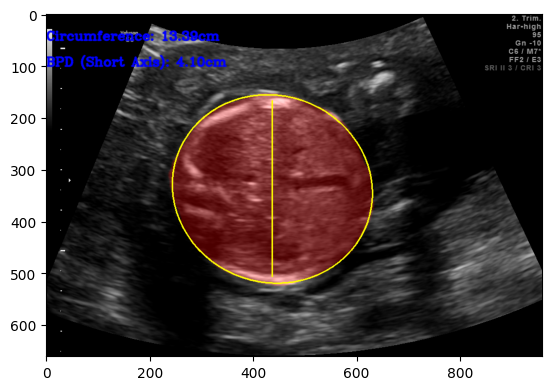

(661, 959)
torch.Size([1, 224, 224])
661 959
(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.1647, 0.0431, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.4510, 0.1725, 0.0000],
         ...,
         [0.3529, 0.4314, 0.4549,  ..., 0.0745, 0.0863, 0.0824],
         [0.3647, 0.4157, 0.4196,  ..., 0.0627, 0.0627, 0.0549],
         [0.3529, 0.4000, 0.3804,  ..., 0.0588, 0.0627, 0.0627]]]),)
Fully connected output: torch.Size([1, 4])
Segmentation output: torch.Size([1, 1, 224, 224])
Class probabilities: tensor([[4.0493e-07, 1.9898e-08, 1.0000e+00, 3.5762e-06]])
Predicted class: Fetal femur

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
SHAPE (661, 959, 3)
<class 'numpy.ndarray'>
[[0 0 1 0 0]
 [0 0 1 0 0]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 1 0 0]]
shape of image (661, 959)


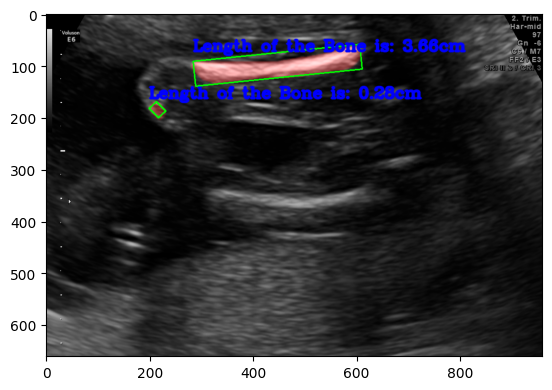

(661, 959)
torch.Size([1, 224, 224])
661 959
(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.1647, 0.0431, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.4510, 0.1725, 0.0000],
         ...,
         [0.2510, 0.2824, 0.2980,  ..., 0.0745, 0.0627, 0.0549],
         [0.2627, 0.2941, 0.2824,  ..., 0.0627, 0.0510, 0.0510],
         [0.3294, 0.3490, 0.3059,  ..., 0.0588, 0.0588, 0.0784]]]),)
Fully connected output: torch.Size([1, 4])
Segmentation output: torch.Size([1, 1, 224, 224])
Class probabilities: tensor([[6.0218e-06, 4.0281e-07, 9.9962e-01, 3.7595e-04]])
Predicted class: Fetal femur

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
SHAPE (661, 959, 3)
<class 'numpy.ndarray'>
[[0 0 1 0 0]
 [0 0 1 0 0]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 1 0 0]]
shape of image (661, 959)


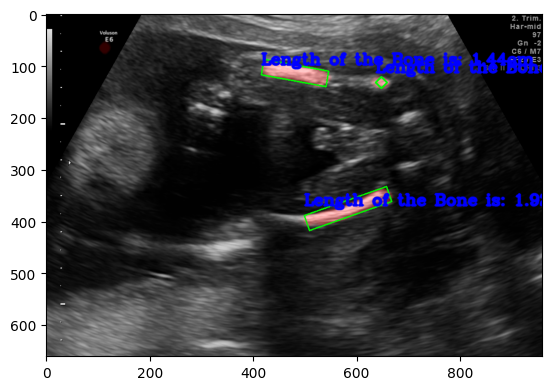

(392, 640)
torch.Size([1, 224, 224])
392 640
(tensor([[[0.0078, 0.0118, 0.0627,  ..., 0.1922, 0.1922, 0.2000],
         [0.1451, 0.1882, 0.1647,  ..., 0.3961, 0.4196, 0.4078],
         [0.1686, 0.1843, 0.0353,  ..., 0.4157, 0.4118, 0.3608],
         ...,
         [0.0353, 0.0431, 0.0392,  ..., 0.1176, 0.1569, 0.2157],
         [0.0392, 0.0510, 0.0314,  ..., 0.1137, 0.1490, 0.2000],
         [0.0431, 0.0627, 0.0392,  ..., 0.1216, 0.1176, 0.1490]]]),)
Fully connected output: torch.Size([1, 4])
Segmentation output: torch.Size([1, 1, 224, 224])
Class probabilities: tensor([[1.6064e-05, 8.9126e-07, 9.9584e-01, 4.1434e-03]])
Predicted class: Fetal femur

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
SHAPE (392, 640, 3)
<class 'numpy.ndarray'>
[[0 0 1 0 0]
 [0 0 1 0 0]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 1 0 0]]
shape of image (392, 640)


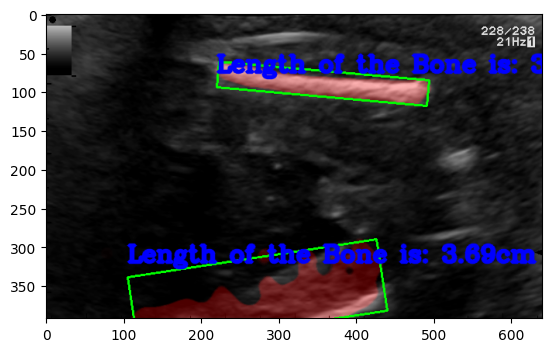

(787, 1137)
torch.Size([1, 224, 224])
787 1137
(tensor([[[0.0157, 0.0157, 0.0157,  ..., 0.0157, 0.0157, 0.0157],
         [0.0000, 0.0000, 0.0000,  ..., 0.0275, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.1686, 0.1373, 0.0275],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]]),)
Fully connected output: torch.Size([1, 4])
Segmentation output: torch.Size([1, 1, 224, 224])
Class probabilities: tensor([[4.8567e-07, 2.3513e-09, 1.0000e+00, 3.9871e-06]])
Predicted class: Fetal femur

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
SHAPE (787, 1137, 3)
<class 'numpy.ndarray'>
[[0 0 1 0 0]
 [0 0 1 0 0]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 1 0 0]]
shape of image (787, 1137)


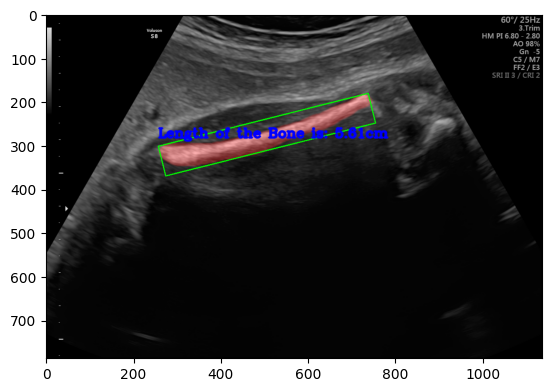

(661, 959)
torch.Size([1, 224, 224])
661 959
(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.1647, 0.0431, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.4510, 0.1725, 0.0000],
         ...,
         [0.1412, 0.1647, 0.1608,  ..., 0.0353, 0.0471, 0.0353],
         [0.1529, 0.1843, 0.1569,  ..., 0.0706, 0.0510, 0.0392],
         [0.1255, 0.1647, 0.1569,  ..., 0.0745, 0.0471, 0.0196]]]),)
Fully connected output: torch.Size([1, 4])
Segmentation output: torch.Size([1, 1, 224, 224])
Class probabilities: tensor([[1.5594e-07, 8.5572e-08, 1.0000e+00, 1.3721e-06]])
Predicted class: Fetal femur

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
SHAPE (661, 959, 3)
<class 'numpy.ndarray'>
[[0 0 1 0 0]
 [0 0 1 0 0]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 1 0 0]]
shape of image (661, 959)


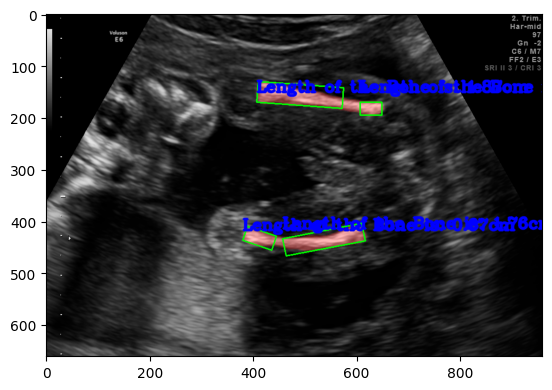

(663, 961)
torch.Size([1, 224, 224])
663 961
(tensor([[[0.1451, 0.1216, 0.1059,  ..., 0.1529, 0.1216, 0.1373],
         [0.1451, 0.1098, 0.0941,  ..., 0.1608, 0.1647, 0.1686],
         [0.1255, 0.0980, 0.0902,  ..., 0.4039, 0.3255, 0.1412],
         ...,
         [0.0314, 0.0235, 0.0118,  ..., 0.0000, 0.0000, 0.0000],
         [0.0078, 0.0078, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000]]]),)
Fully connected output: torch.Size([1, 4])
Segmentation output: torch.Size([1, 1, 224, 224])
Class probabilities: tensor([[1.3117e-08, 5.6116e-10, 1.0000e+00, 5.6276e-09]])
Predicted class: Fetal femur

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
SHAPE (663, 961, 3)
<class 'numpy.ndarray'>
[[0 0 1 0 0]
 [0 0 1 0 0]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 1 0 0]]
shape of image (663, 961)


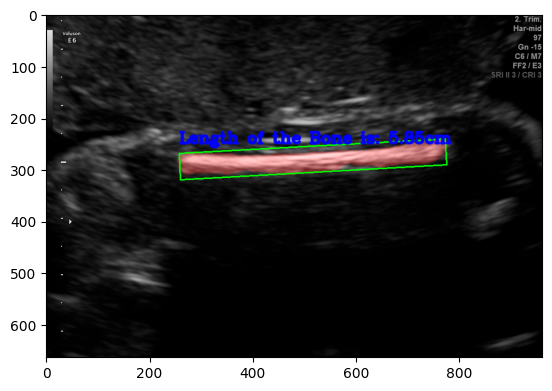

(661, 959)
torch.Size([1, 224, 224])
661 959
(tensor([[[0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0078, 0.0078, 0.0078,  ..., 0.1804, 0.0549, 0.0078],
         [0.0078, 0.0078, 0.0078,  ..., 0.4824, 0.1922, 0.0078],
         ...,
         [0.0157, 0.0196, 0.0196,  ..., 0.0196, 0.0196, 0.0196],
         [0.0157, 0.0196, 0.0196,  ..., 0.0196, 0.0196, 0.0196],
         [0.0157, 0.0196, 0.0196,  ..., 0.0196, 0.0196, 0.0196]]]),)
Fully connected output: torch.Size([1, 4])
Segmentation output: torch.Size([1, 1, 224, 224])
Class probabilities: tensor([[2.9640e-08, 2.6577e-08, 1.0000e+00, 9.6802e-07]])
Predicted class: Fetal femur

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
SHAPE (661, 959, 3)
<class 'numpy.ndarray'>
[[0 0 1 0 0]
 [0 0 1 0 0]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 1 0 0]]
shape of image (661, 959)


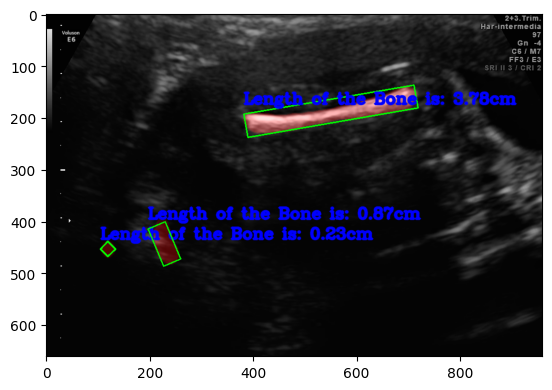

(661, 959)
torch.Size([1, 224, 224])
661 959
(tensor([[[0.2275, 0.2784, 0.2627,  ..., 0.0431, 0.0431, 0.0275],
         [0.3176, 0.3804, 0.3647,  ..., 0.2157, 0.0902, 0.0235],
         [0.3294, 0.4078, 0.3961,  ..., 0.4824, 0.2078, 0.0275],
         ...,
         [0.1059, 0.1294, 0.1373,  ..., 0.4275, 0.4275, 0.4353],
         [0.1137, 0.1333, 0.1333,  ..., 0.4627, 0.4588, 0.4667],
         [0.1176, 0.1412, 0.1373,  ..., 0.4706, 0.4549, 0.4510]]]),)
Fully connected output: torch.Size([1, 4])
Segmentation output: torch.Size([1, 1, 224, 224])
Class probabilities: tensor([[3.8926e-08, 2.1007e-08, 1.0000e+00, 1.1136e-06]])
Predicted class: Fetal femur

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
SHAPE (661, 959, 3)
<class 'numpy.ndarray'>
[[0 0 1 0 0]
 [0 0 1 0 0]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 1 0 0]]
shape of image (661, 959)


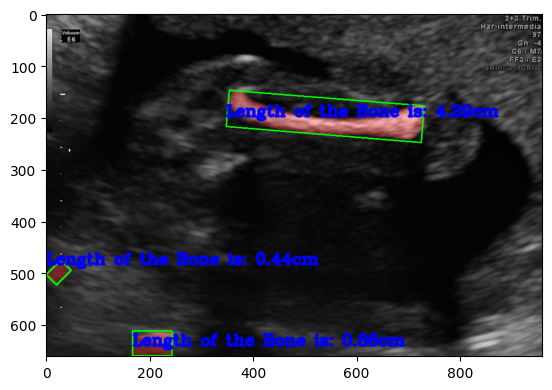

(661, 959)
torch.Size([1, 224, 224])
661 959
(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.1647, 0.0431, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.4510, 0.1725, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]]),)
Fully connected output: torch.Size([1, 4])
Segmentation output: torch.Size([1, 1, 224, 224])
Class probabilities: tensor([[2.5315e-06, 7.1972e-10, 1.0000e+00, 1.9780e-08]])
Predicted class: Fetal femur

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
SHAPE (661, 959, 3)
<class 'numpy.ndarray'>
[[0 0 1 0 0]
 [0 0 1 0 0]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 1 0 0]]
shape of image (661, 959)


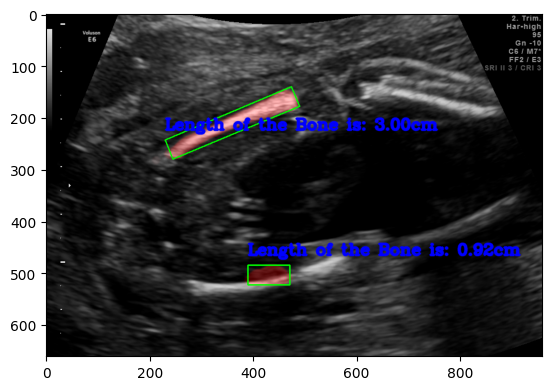

(392, 640)
torch.Size([1, 224, 224])
392 640
(tensor([[[0.0118, 0.0157, 0.1333,  ..., 0.0000, 0.0000, 0.0000],
         [0.1765, 0.2784, 0.3176,  ..., 0.0000, 0.0000, 0.0000],
         [0.1843, 0.2275, 0.0510,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0471, 0.0392, 0.0471],
         [0.0000, 0.0000, 0.0000,  ..., 0.0275, 0.0353, 0.0549],
         [0.0000, 0.0000, 0.0000,  ..., 0.0275, 0.0431, 0.0667]]]),)
Fully connected output: torch.Size([1, 4])
Segmentation output: torch.Size([1, 1, 224, 224])
Class probabilities: tensor([[2.3348e-06, 1.9310e-06, 9.9982e-01, 1.7756e-04]])
Predicted class: Fetal femur

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
SHAPE (392, 640, 3)
<class 'numpy.ndarray'>
[[0 0 1 0 0]
 [0 0 1 0 0]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 1 0 0]]
shape of image (392, 640)


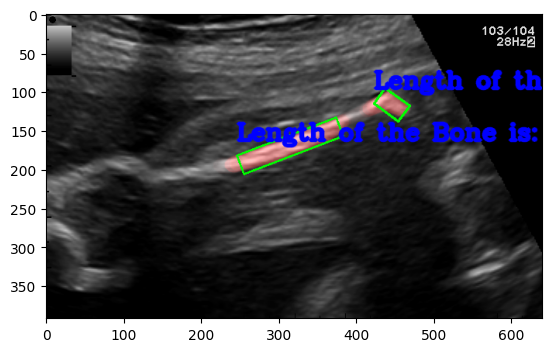

(663, 961)
torch.Size([1, 224, 224])
663 961
(tensor([[[0.3804, 0.3765, 0.3373,  ..., 0.1529, 0.1333, 0.1176],
         [0.3451, 0.3569, 0.3490,  ..., 0.1451, 0.1333, 0.1294],
         [0.2471, 0.2353, 0.2392,  ..., 0.3882, 0.3176, 0.1725],
         ...,
         [0.0353, 0.0353, 0.0353,  ..., 0.0000, 0.0000, 0.0000],
         [0.0392, 0.0314, 0.0275,  ..., 0.0000, 0.0000, 0.0000],
         [0.0471, 0.0431, 0.0353,  ..., 0.0000, 0.0000, 0.0000]]]),)
Fully connected output: torch.Size([1, 4])
Segmentation output: torch.Size([1, 1, 224, 224])
Class probabilities: tensor([[3.4600e-07, 1.0810e-07, 1.0000e+00, 3.4741e-06]])
Predicted class: Fetal femur

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
SHAPE (663, 961, 3)
<class 'numpy.ndarray'>
[[0 0 1 0 0]
 [0 0 1 0 0]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 1 0 0]]
shape of image (663, 961)


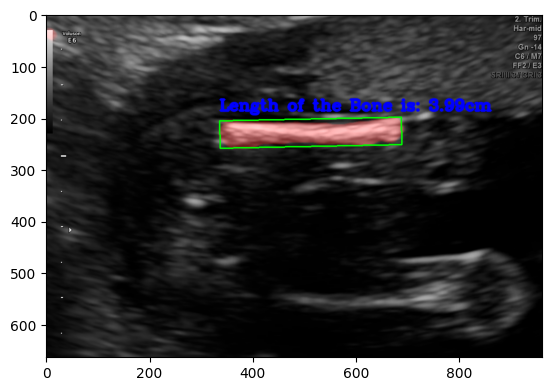

(661, 959)
torch.Size([1, 224, 224])
661 959
(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.1725, 0.1255, 0.0902],
         [0.0000, 0.0000, 0.0000,  ..., 0.4353, 0.3843, 0.2941],
         [0.0000, 0.0000, 0.0000,  ..., 0.4706, 0.4549, 0.2980],
         ...,
         [0.0118, 0.0039, 0.0039,  ..., 0.3255, 0.2431, 0.2000],
         [0.0118, 0.0078, 0.0078,  ..., 0.2824, 0.2235, 0.1765],
         [0.0039, 0.0039, 0.0039,  ..., 0.2706, 0.2078, 0.1804]]]),)
Fully connected output: torch.Size([1, 4])
Segmentation output: torch.Size([1, 1, 224, 224])
Class probabilities: tensor([[3.9885e-08, 9.3867e-09, 1.0000e+00, 1.0458e-06]])
Predicted class: Fetal femur

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
SHAPE (661, 959, 3)
<class 'numpy.ndarray'>
[[0 0 1 0 0]
 [0 0 1 0 0]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 1 0 0]]
shape of image (661, 959)


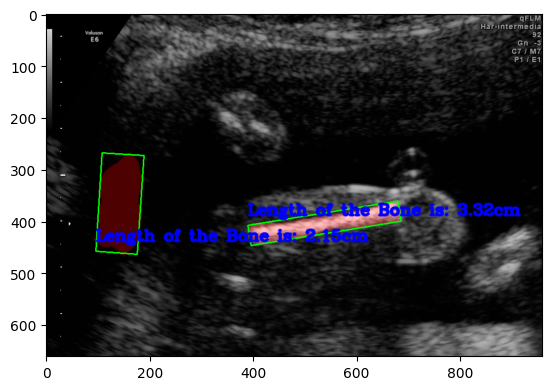

(392, 640)
torch.Size([1, 224, 224])
392 640
(tensor([[[0.0078, 0.0118, 0.0588,  ..., 0.0392, 0.0314, 0.0314],
         [0.1294, 0.1765, 0.1647,  ..., 0.0784, 0.0706, 0.0706],
         [0.1529, 0.1647, 0.0314,  ..., 0.0588, 0.0627, 0.0627],
         ...,
         [0.0275, 0.0353, 0.1137,  ..., 0.0784, 0.0980, 0.0980],
         [0.0980, 0.1333, 0.1608,  ..., 0.1059, 0.1098, 0.0980],
         [0.1412, 0.1961, 0.2000,  ..., 0.1059, 0.0980, 0.0902]]]),)
Fully connected output: torch.Size([1, 4])
Segmentation output: torch.Size([1, 1, 224, 224])
Class probabilities: tensor([[1.2191e-03, 2.5893e-04, 8.9182e-01, 1.0670e-01]])
Predicted class: Fetal femur

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
SHAPE (392, 640, 3)
<class 'numpy.ndarray'>
[[0 0 1 0 0]
 [0 0 1 0 0]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 1 0 0]]
shape of image (392, 640)


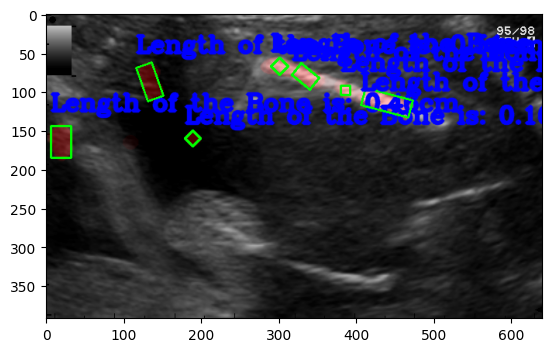

(787, 1137)
torch.Size([1, 224, 224])
787 1137
(tensor([[[0.0157, 0.0157, 0.0157,  ..., 0.0157, 0.0157, 0.0157],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.1255, 0.1098, 0.0039],
         ...,
         [0.6196, 0.5922, 0.6000,  ..., 0.1098, 0.0941, 0.0824],
         [0.6627, 0.6314, 0.5961,  ..., 0.1059, 0.1176, 0.1294],
         [0.5647, 0.5490, 0.5137,  ..., 0.1059, 0.1333, 0.1216]]]),)
Fully connected output: torch.Size([1, 4])
Segmentation output: torch.Size([1, 1, 224, 224])
Class probabilities: tensor([[5.6316e-07, 1.6581e-06, 9.9996e-01, 3.9632e-05]])
Predicted class: Fetal femur

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
SHAPE (787, 1137, 3)
<class 'numpy.ndarray'>
[[0 0 1 0 0]
 [0 0 1 0 0]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 1 0 0]]
shape of image (787, 1137)


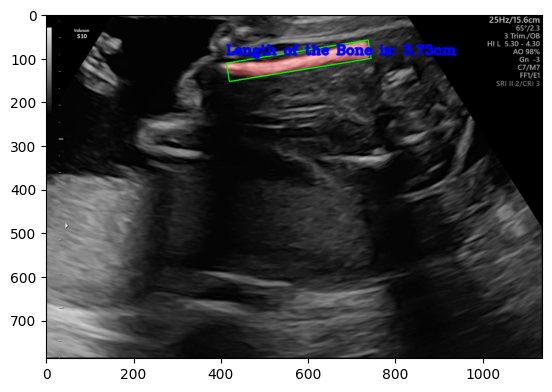

(661, 959)
torch.Size([1, 224, 224])
661 959
(tensor([[[0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0078, 0.0078, 0.0078,  ..., 0.1725, 0.0510, 0.0078],
         [0.0078, 0.0078, 0.0078,  ..., 0.4510, 0.1765, 0.0078],
         ...,
         [0.5725, 0.6745, 0.6824,  ..., 0.0863, 0.0824, 0.0784],
         [0.5686, 0.6667, 0.6745,  ..., 0.0863, 0.0824, 0.0941],
         [0.5765, 0.7098, 0.7098,  ..., 0.0902, 0.1020, 0.1137]]]),)
Fully connected output: torch.Size([1, 4])
Segmentation output: torch.Size([1, 1, 224, 224])
Class probabilities: tensor([[4.0768e-08, 1.8374e-10, 1.0000e+00, 4.0737e-07]])
Predicted class: Fetal femur

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
SHAPE (661, 959, 3)
<class 'numpy.ndarray'>
[[0 0 1 0 0]
 [0 0 1 0 0]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 1 0 0]]
shape of image (661, 959)


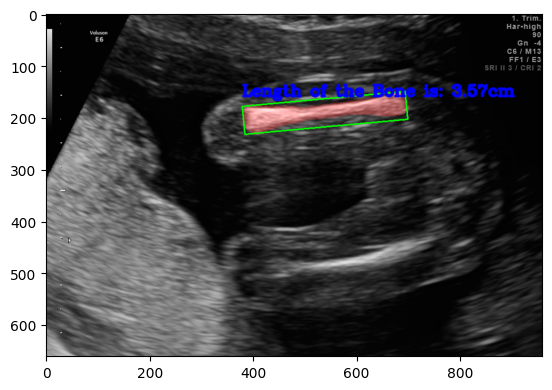

(661, 959)
torch.Size([1, 224, 224])
661 959
(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.1647, 0.0431, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.4510, 0.1725, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]]),)
Fully connected output: torch.Size([1, 4])
Segmentation output: torch.Size([1, 1, 224, 224])
Class probabilities: tensor([[1.0101e-09, 2.5762e-10, 1.0000e+00, 7.6018e-08]])
Predicted class: Fetal femur

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
SHAPE (661, 959, 3)
<class 'numpy.ndarray'>
[[0 0 1 0 0]
 [0 0 1 0 0]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 1 0 0]]
shape of image (661, 959)


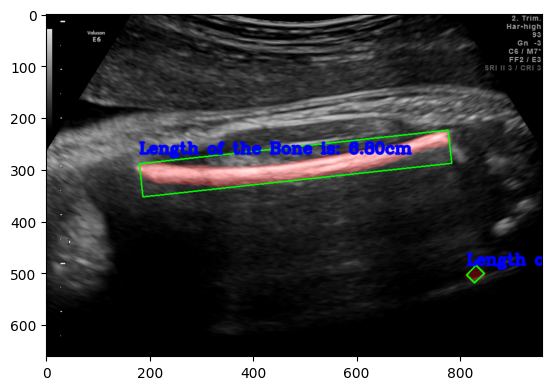

(392, 640)
torch.Size([1, 224, 224])
392 640
(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0157, 0.0196, 0.0196,  ..., 0.0824, 0.0784, 0.0784],
         [0.0118, 0.0235, 0.0157,  ..., 0.0549, 0.0510, 0.0588],
         [0.0118, 0.0196, 0.0078,  ..., 0.0627, 0.0627, 0.0745]]]),)
Fully connected output: torch.Size([1, 4])
Segmentation output: torch.Size([1, 1, 224, 224])
Class probabilities: tensor([[6.7498e-05, 9.5158e-05, 9.1751e-01, 8.2324e-02]])
Predicted class: Fetal femur

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
SHAPE (392, 640, 3)
<class 'numpy.ndarray'>
[[0 0 1 0 0]
 [0 0 1 0 0]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 1 0 0]]
shape of image (392, 640)


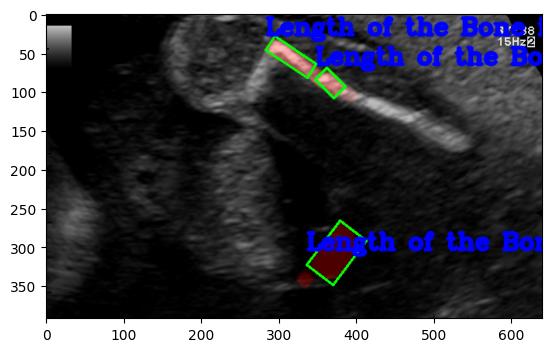

(661, 959)
torch.Size([1, 224, 224])
661 959
(tensor([[[0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0078, 0.0078, 0.0078,  ..., 0.1804, 0.0549, 0.0078],
         [0.0078, 0.0078, 0.0078,  ..., 0.4824, 0.1922, 0.0078],
         ...,
         [0.3647, 0.4039, 0.3686,  ..., 0.0471, 0.0510, 0.0549],
         [0.4235, 0.4902, 0.4588,  ..., 0.0588, 0.0588, 0.0627],
         [0.4235, 0.5216, 0.5216,  ..., 0.0784, 0.0824, 0.0902]]]),)
Fully connected output: torch.Size([1, 4])
Segmentation output: torch.Size([1, 1, 224, 224])
Class probabilities: tensor([[7.8572e-06, 2.7589e-08, 9.9906e-01, 9.3458e-04]])
Predicted class: Fetal femur

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]]
SHAPE (661, 959, 3)
<class 'numpy.ndarray'>
[[0 0 1 0 0]
 [0 0 1 0 0]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 1 0 0]]
shape of image (661, 959)


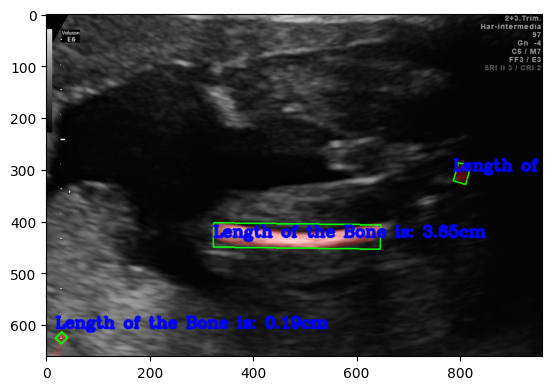

(661, 959)
torch.Size([1, 224, 224])
661 959
(tensor([[[0.1020, 0.1294, 0.1412,  ..., 0.0627, 0.0824, 0.0824],
         [0.1255, 0.1451, 0.1529,  ..., 0.2471, 0.1647, 0.1294],
         [0.1451, 0.1529, 0.1412,  ..., 0.4549, 0.2392, 0.1412],
         ...,
         [0.1882, 0.2118, 0.1843,  ..., 0.2431, 0.2471, 0.2471],
         [0.1412, 0.1725, 0.1647,  ..., 0.2157, 0.2000, 0.1922],
         [0.0980, 0.1216, 0.1216,  ..., 0.1529, 0.1451, 0.1765]]]),)
Fully connected output: torch.Size([1, 4])
Segmentation output: torch.Size([1, 1, 224, 224])
Class probabilities: tensor([[7.7332e-08, 5.0954e-12, 1.0000e+00, 1.1137e-09]])
Predicted class: Fetal femur

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
SHAPE (661, 959, 3)
<class 'numpy.ndarray'>
[[0 0 1 0 0]
 [0 0 1 0 0]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 1 0 0]]
shape of image (661, 959)


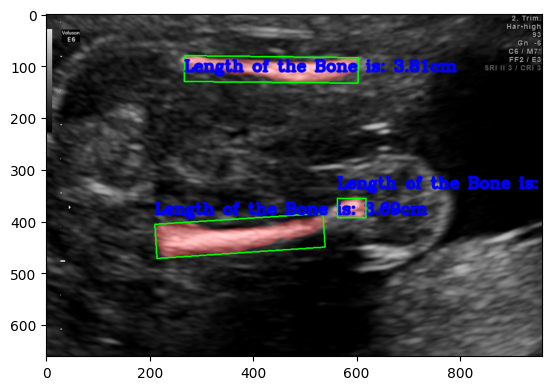

(661, 959)
torch.Size([1, 224, 224])
661 959
(tensor([[[0.1255, 0.1529, 0.1843,  ..., 0.0000, 0.0000, 0.0000],
         [0.1961, 0.2275, 0.2431,  ..., 0.1647, 0.0431, 0.0000],
         [0.2392, 0.2745, 0.2706,  ..., 0.4510, 0.1725, 0.0000],
         ...,
         [0.3176, 0.3922, 0.4078,  ..., 0.0667, 0.0745, 0.0824],
         [0.3137, 0.4039, 0.4157,  ..., 0.0784, 0.0745, 0.0667],
         [0.3294, 0.4275, 0.4627,  ..., 0.0667, 0.0627, 0.0588]]]),)
Fully connected output: torch.Size([1, 4])
Segmentation output: torch.Size([1, 1, 224, 224])
Class probabilities: tensor([[1.1519e-06, 7.6843e-08, 9.9999e-01, 7.4916e-06]])
Predicted class: Fetal femur

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
SHAPE (661, 959, 3)
<class 'numpy.ndarray'>
[[0 0 1 0 0]
 [0 0 1 0 0]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 1 0 0]]
shape of image (661, 959)


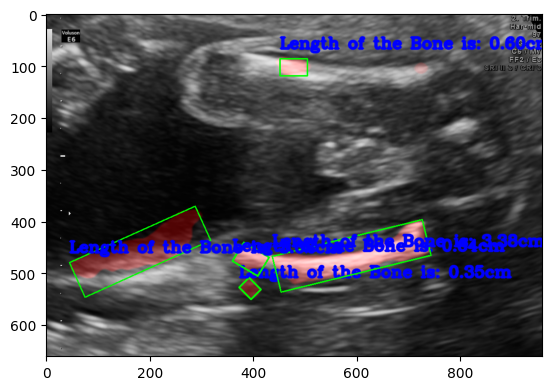

(392, 640)
torch.Size([1, 224, 224])
392 640
(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.2902, 0.4078, 0.4118,  ..., 0.3922, 0.3843, 0.3843],
         [0.2902, 0.3922, 0.4078,  ..., 0.4000, 0.3922, 0.3882],
         [0.3020, 0.3922, 0.3922,  ..., 0.4118, 0.4078, 0.4078]]]),)
Fully connected output: torch.Size([1, 4])
Segmentation output: torch.Size([1, 1, 224, 224])
Class probabilities: tensor([[1.8600e-01, 3.0328e-03, 4.0460e-06, 8.1096e-01]])
Predicted class: other

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
SHAPE (392, 640, 3)
<class 'numpy.ndarray'>
[[0 0 1 0 0]
 [0 0 1 0 0]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 1 0 0]]
shape of image (392, 640)


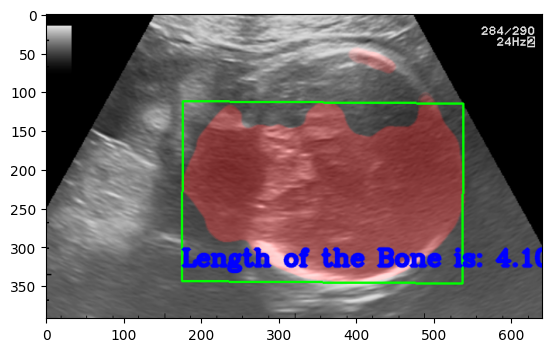

(661, 959)
torch.Size([1, 224, 224])
661 959
(tensor([[[0.0157, 0.0118, 0.0118,  ..., 0.2235, 0.2549, 0.3373],
         [0.0157, 0.0118, 0.0039,  ..., 0.4510, 0.4196, 0.4235],
         [0.0078, 0.0078, 0.0039,  ..., 0.4706, 0.4549, 0.3725],
         ...,
         [0.0745, 0.0745, 0.0627,  ..., 0.2000, 0.2078, 0.2078],
         [0.0980, 0.1216, 0.1098,  ..., 0.1765, 0.1686, 0.1608],
         [0.0784, 0.1098, 0.1255,  ..., 0.1686, 0.1725, 0.1765]]]),)
Fully connected output: torch.Size([1, 4])
Segmentation output: torch.Size([1, 1, 224, 224])
Class probabilities: tensor([[9.9989e-01, 1.9369e-06, 4.1548e-05, 6.8832e-05]])
Predicted class: Fetal brain

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
SHAPE (661, 959, 3)
<class 'numpy.ndarray'>
[[0 0 1 0 0]
 [0 0 1 0 0]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 1 0 0]]
shape of image (661, 959)
B 263.7894592285156
574.2872314453125
291.1398620605469
(574, 545)
(574, 37)
Ellipse fi

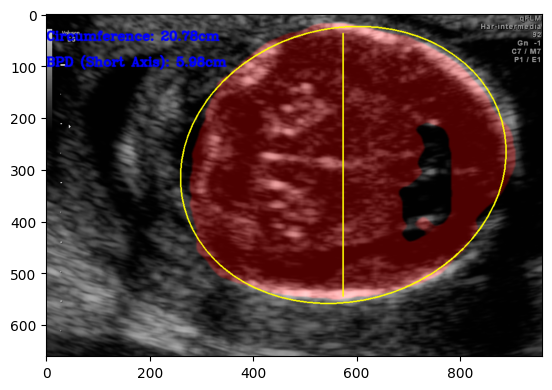

(661, 959)
torch.Size([1, 224, 224])
661 959
(tensor([[[0.0000, 0.0000, 0.0235,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0627,  ..., 0.1647, 0.0431, 0.0000],
         [0.0000, 0.0000, 0.1059,  ..., 0.4510, 0.1725, 0.0000],
         ...,
         [0.0039, 0.0078, 0.0118,  ..., 0.4745, 0.5216, 0.5176],
         [0.0039, 0.0000, 0.0000,  ..., 0.4784, 0.4824, 0.4588],
         [0.0118, 0.0118, 0.0196,  ..., 0.4471, 0.4275, 0.3882]]]),)
Fully connected output: torch.Size([1, 4])
Segmentation output: torch.Size([1, 1, 224, 224])
Class probabilities: tensor([[9.9913e-01, 5.0905e-05, 1.5015e-06, 8.1513e-04]])
Predicted class: Fetal brain

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
SHAPE (661, 959, 3)
<class 'numpy.ndarray'>
[[0 0 1 0 0]
 [0 0 1 0 0]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 1 0 0]]
shape of image (661, 959)
B 271.3670654296875
338.03350830078125
321.0098876953125
(338, 591)
(338, 51)
Ellipse f

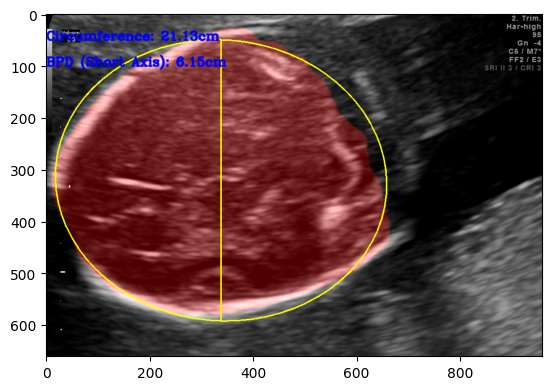

(392, 640)
torch.Size([1, 224, 224])
392 640
(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]),)
Fully connected output: torch.Size([1, 4])
Segmentation output: torch.Size([1, 1, 224, 224])
Class probabilities: tensor([[2.2955e-02, 2.9446e-04, 3.3829e-05, 9.7672e-01]])
Predicted class: other

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
SHAPE (392, 640, 3)
<class 'numpy.ndarray'>
[[0 0 1 0 0]
 [0 0 1 0 0]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 1 0 0]]
shape of image (392, 640)


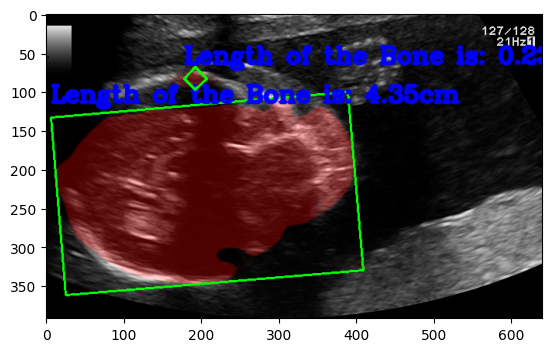

(661, 959)
torch.Size([1, 224, 224])
661 959
(tensor([[[0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0078, 0.0078, 0.0078,  ..., 0.1804, 0.0549, 0.0078],
         [0.0078, 0.0078, 0.0078,  ..., 0.4824, 0.1922, 0.0078],
         ...,
         [0.5020, 0.5804, 0.5373,  ..., 0.0157, 0.0157, 0.0157],
         [0.4706, 0.5843, 0.5843,  ..., 0.0157, 0.0157, 0.0196],
         [0.4235, 0.5451, 0.5804,  ..., 0.0157, 0.0157, 0.0196]]]),)
Fully connected output: torch.Size([1, 4])
Segmentation output: torch.Size([1, 1, 224, 224])
Class probabilities: tensor([[1.0000e+00, 7.7330e-10, 6.9198e-10, 6.2663e-09]])
Predicted class: Fetal brain

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
SHAPE (661, 959, 3)
<class 'numpy.ndarray'>
[[0 0 1 0 0]
 [0 0 1 0 0]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 1 0 0]]
shape of image (661, 959)
B 214.6746368408203
523.3794555664062
267.3593444824219
(523, 481)
(523, 53)
Ellipse fi

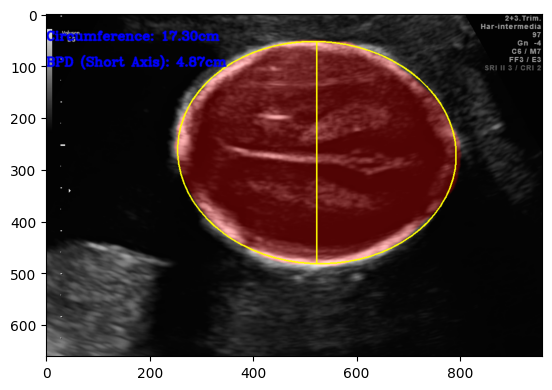

(661, 959)
torch.Size([1, 224, 224])
661 959
(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.1647, 0.0431, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.4510, 0.1725, 0.0000],
         ...,
         [0.3020, 0.3686, 0.4118,  ..., 0.0392, 0.0431, 0.0510],
         [0.2902, 0.3412, 0.3373,  ..., 0.0314, 0.0431, 0.0471],
         [0.2902, 0.3490, 0.3294,  ..., 0.0235, 0.0314, 0.0392]]]),)
Fully connected output: torch.Size([1, 4])
Segmentation output: torch.Size([1, 1, 224, 224])
Class probabilities: tensor([[1.0000e+00, 1.5561e-07, 2.0262e-08, 2.1678e-08]])
Predicted class: Fetal brain

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
SHAPE (661, 959, 3)
<class 'numpy.ndarray'>
[[0 0 1 0 0]
 [0 0 1 0 0]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 1 0 0]]
shape of image (661, 959)
B 233.9368133544922
538.103759765625
272.27728271484375
(538, 503)
(538, 41)
Ellipse fi

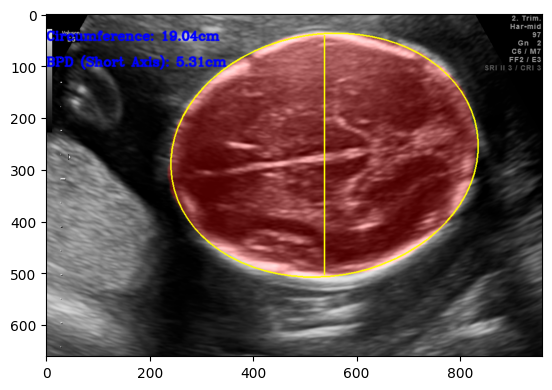

(663, 961)
torch.Size([1, 224, 224])
663 961
(tensor([[[0.0275, 0.0275, 0.0275,  ..., 0.0275, 0.0275, 0.0275],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.3412, 0.2314, 0.0039],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]]),)
Fully connected output: torch.Size([1, 4])
Segmentation output: torch.Size([1, 1, 224, 224])
Class probabilities: tensor([[9.9924e-01, 5.6028e-04, 1.0919e-04, 9.0498e-05]])
Predicted class: Fetal brain

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
SHAPE (663, 961, 3)
<class 'numpy.ndarray'>
[[0 0 1 0 0]
 [0 0 1 0 0]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 1 0 0]]
shape of image (663, 961)
B 156.0211944580078
478.9243469238281
289.36798095703125
(478, 445)
(478, 133)
Ellipse 

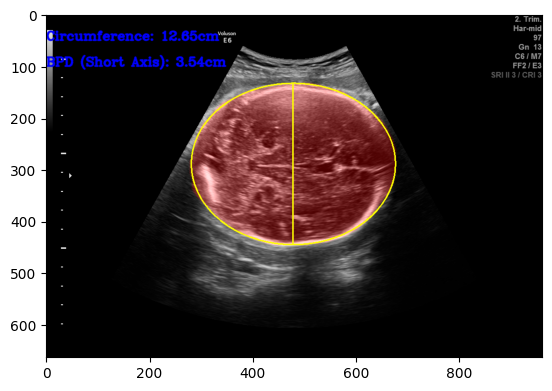

(663, 961)
torch.Size([1, 224, 224])
663 961
(tensor([[[0.0275, 0.0275, 0.0275,  ..., 0.0275, 0.0275, 0.0275],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.3333, 0.2275, 0.0039],
         ...,
         [0.0275, 0.0275, 0.0275,  ..., 0.2980, 0.2588, 0.2471],
         [0.0275, 0.0275, 0.0235,  ..., 0.2706, 0.2627, 0.3020],
         [0.0235, 0.0275, 0.0275,  ..., 0.2941, 0.3098, 0.3137]]]),)


In [ ]:
#Inference:

folder="/Users/vinu/Downloads/FETAL_PLANES_ZENODO/Images"
output_folder="data_new"
segment_folder='segment'
blend_folder="blend"
predicted_classes=[]

df=pd.read_excel("sampled_files_with_columns.xlsx")
data=df["Image_name"]

for image_name in data:
    image_tensor,height,width,image_np=img_to_tensor(image_name,folder,output_folder)
    print(height,width)

    with torch.no_grad():
        fc_output, segmentation_output = model(image_tensor)

    print("Fully connected output:", fc_output.shape)
    print("Segmentation output:", segmentation_output.shape)
    softmax = torch.nn.Softmax(dim=1)

    class_probs = softmax(fc_output)
    predicted_class_index = torch.argmax(class_probs, dim=1)
    predicted_classes.append(classes[predicted_class_index.item()]) 


    print("Class probabilities:", class_probs)
    print("Predicted class:", classes[predicted_class_index])
    print()
    predicted_class=classes[predicted_class_index]
    mask=mask_generation(segmentation_output,width,height)
    print(type(mask))
    processed_mask=mask_processing(mask)

    blended_image=overlay(processed_mask,image_np)
    final_image=contour_detect(processed_mask,predicted_class,blended_image)
    # blended_rgb=cv2.cvtColor(blended_image,cv2.COLOR_BGR2RGB)
    final_rgb=cv2.cvtColor(final_image,cv2.COLOR_BGR2RGB)
    plt.imshow(final_rgb)
    plt.show()

    


    

